# Import & Config

In [2]:
!pip install hazm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.3 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=42f3fe02911b255a68cf28ddad8877376be11fd8e2192a0f9ddf5833a5afc703
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable # This package has predefined gradient and derivative functions

import hazm
import string
import re
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import sentencepiece as spm

In [ ]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if train_on_gpu else 'cpu')

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

# Data

In [ ]:
#-------------------------------------------------------------------#

## Download dataset from Kaggle

In [12]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt
!kaggle datasets download alioraji/persian-stop-words -f Persian_Stop_Words.txt
!unzip Persian-WikiText-1.txt.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
Persian-WikiText-1.txt.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/alioraji/persian-stop-words
License(s): other
Persian_Stop_Words.txt: Skipping, found more recently modified local copy (use --force to force download)
Archive:  Persian-WikiText-1.txt.zip
replace Persian-WikiText-1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Persian-WikiText-1.txt  


## Data Preprocessing

In [13]:
with open("Persian-WikiText-1.txt", encoding="utf-8") as file:
    text = file.read()

In [14]:
without_ref_text = re.sub(r'\[\d+\]', '', text)
without_url_text = re.sub(r'https?:\/\/\S+', '', without_ref_text)
without_tag_text = re.sub(r'<.*?>', '', without_url_text)
without_not_persian_text = re.sub(r'[^\u0600-\u06FF\uFB50-\uFDFF\u06F0-\u06F9\u0030-\u0039\s]', '', without_tag_text)
# without_empty_line = re.sub("\n", " ", without_not_persian_text)

In [15]:
print("without_ref_text : \n")
print(without_ref_text[:1000])
print('-'*70)
print("without_url_text : \n")
print(without_url_text[:1000])
print('-'*70)
print("without_tag_text : \n")
print(without_tag_text[:1000])
print('-'*70)
print("without_not_persian_text : \n")
print(without_not_persian_text[:1000])
print('-'*70)
# print("without_empty_line : \n")
# print(without_empty_line[:1000])

without_ref_text : 

عنوان مقاله: صفحهٔ اصلی

<templatestyles src="صفحه اصلی/



عنوان مقاله: ویکی پدیا

ویکی پدیا (کوته نوشت به صورت «وپ» و «WP») یک دانشنامه برخط چندزبانه مبتنی بر وب با محتوای آزاد و همکاری باز است که با همکاری افراد داوطلب نوشته می شود و هر کسی که به اینترنت و وب دسترسی داشته باشد می تواند مقالات آن را ببیند و ویرایش کند. نام ویکی پدیا واژه ای ترکیبی است که از واژه های ویکی (وبگاه مشارکتی) و اِنسایکلوپدیا (Encyclopedia) (دانشنامه یا دائرةالمعارف) گرفته شده است. هدف ویکی پدیا آفرینش و انتشار جهانی یک دانشنامه با محتوای آزاد به تمامی زبان های زندهٔ دنیا است.

ویکی پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ (۲۶ دی ۱۳۷۹) به صورت مکملی برای دانشنامهٔ تخصصی نیوپدیا نوشته شد. بنیان گذاران آن «جیمی ویلز» و «لری سنگر» هستند. هم اکنون بنیاد غیرانتفاعی ویکی مدیا پروژهٔ ویکی پدیا را پشتیبانی می کند. میزبان های اینترنتی اصلی این وبگاه در شهر تامپای فلوریدا هستند. همچنین میزبان های اضافی دیگری هم در شهرهای آمستردام و سئول به این وبگاه یاری می رسانند.

"ویکی پدیا" از پایان آوریل ۲۰۰۷ ت

In [16]:
normalized_text = hazm.Normalizer().normalize(without_not_persian_text)

In [17]:
with open("preprocessed_text.txt", "w", encoding="utf-8") as file:
    file.write(normalized_text)
print(normalized_text[:1000])

عنوان مقاله صفحه اصلی

صفحه اصلی

عنوان مقاله ویکی پدیا

ویکی پدیا کوته نوشت به صورت وپ و یک دانشنامه برخط چندزبانه مبتنی بر وب با محتوای آزاد و همکاری باز است که با همکاری افراد داوطلب نوشته می‌شود و هر کسی که به اینترنت و وب دسترسی داشته باشد می‌تواند مقالات آن را ببیند و ویرایش کند نام ویکی پدیا واژه‌ای ترکیبی است که از واژه‌های ویکی وبگاه مشارکتی و انسایکلوپدیا دانشنامه یا دائرةالمعارف گرفته‌شده است هدف ویکی پدیا آفرینش و انتشار جهانی یک دانشنامه با محتوای آزاد به تمامی زبان‌های زنده دنیا است

ویکی پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ ۲۶ دی ۱۳۷۹ به صورت مکملی برای دانشنامه تخصصی نیوپدیا نوشته شد بنیان گذاران آن جیمی ویلز و لری سنگر هستند هم‌اکنون بنیاد غیرانتفاعی ویکی مدیا پروژه ویکی پدیا را پشتیبانی می‌کند میزبان‌های اینترنتی اصلی این وبگاه در شهر تامپای فلوریدا هستند همچنین میزبان‌های اضافی دیگری هم در شهرهای آمستردام و سئول به این وبگاه یاری می‌رسانند

ویکی پدیا از پایان آوریل ۲۰۰۷ تا اکتبر ۲۰۱۹، یکی از ۱۰ وبگاه برتر جهان از لحاظ شمار بازدیدکنندگان بوده است که بیش از نیمی از با

In [19]:
preprocess_text = normalized_text
spm.SentencePieceTrainer.train(input='preprocessed_text.txt', model_prefix='bpe', vocab_size=32000)
sp = spm.SentencePieceProcessor(model_file='bpe.model')
tokens = sp.encode(preprocess_text, out_type=int)

In [20]:
print(len(tokens))

12382166


In [21]:
print(tokens[:100])

[32, 57, 762, 138, 762, 138, 32, 57, 1239, 1578, 1239, 1578, 12158, 890, 6, 67, 3, 2630, 3, 23, 2283, 15625, 27286, 38, 71, 2089, 27, 1337, 14, 3236, 383, 3, 640, 452, 10, 9, 14, 640, 350, 6890, 192, 8, 25, 3, 51, 649, 9, 6, 2265, 3, 1337, 1529, 116, 44, 8, 229, 2437, 16, 11, 7327, 3, 3024, 40, 35, 1239, 1578, 251, 29, 2257, 10, 9, 7, 251, 13, 1239, 3933, 19782, 3, 856, 4420, 4552, 6649, 10224, 2283, 33, 6163, 0, 6544, 106, 21, 10, 573, 1239, 1578, 4039, 3, 688, 221, 23, 2283]


In [22]:
new_tokens = tokens[:300000]
n = 4
inp, tar = [], []
for i in range(len(new_tokens)-n):
    inp.append(new_tokens[i:i+n])
    tar.append(new_tokens[i+n])
inp = np.array(inp)
tar = np.array(tar)

In [23]:
from torch.utils.data import TensorDataset, DataLoader, random_split
inp_tensor = torch.tensor(np.array(inp))  # Shape: [num_samples, context_size]
tar_tensor = torch.tensor(np.array(tar)).squeeze()  # Shape: [num_samples]

dataset = TensorDataset(inp_tensor, tar_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define the DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(21875, 4688, 4688)

In [24]:
class GRU(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output[:, -1, :])  # Use the last output
        return output

In [66]:
input_size = 32000
embed_size = 32
hidden_size = 24
n_layers=1
model = GRU(input_size, embed_size, hidden_size, n_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
model.to(device)

GRU(
  (embedding): Embedding(32000, 32)
  (rnn): LSTM(32, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=32000, bias=True)
)

In [57]:
def train():
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        outputs = model(inputs.to(device))

        loss = criterion(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

In [58]:
def eval():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [59]:
def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

In [67]:
n_epochs = 15

train_losses = []
val_losses = []
num = 1
train_avg = 0
val_avg = 0

for epoch in range(n_epochs):
    model.train()
    t_loss = train()

    train_avg += t_loss
    # scheduler.step()
    v_loss = eval()
    val_avg += v_loss
    val_perplexity = calculate_perplexity(v_loss/num)
    if (epoch + 1) % num == 0:
      print(f'Epoch {epoch + 1}/{n_epochs}')
      print(f'Train Loss: {t_loss:.4f}')
      print(f'Validation Loss: {v_loss:.4f}')
      print(f'Validation Perplexity: {val_perplexity:.4f}')
      # print(f'Current Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
      train_losses.append(t_loss/num)
      val_losses.append(v_loss/num)
      t_loss = 0
      v_loss = 0

Epoch 1/15
Train Loss: 7.0069
Validation Loss: 6.7299
Validation Perplexity: 837.0659
Epoch 2/15
Train Loss: 6.5532
Validation Loss: 6.5953
Validation Perplexity: 731.6628
Epoch 3/15
Train Loss: 6.4037
Validation Loss: 6.5368
Validation Perplexity: 690.0760
Epoch 4/15
Train Loss: 6.3156
Validation Loss: 6.5028
Validation Perplexity: 666.9745
Epoch 5/15
Train Loss: 6.2528
Validation Loss: 6.4770
Validation Perplexity: 649.9902
Epoch 6/15
Train Loss: 6.2025
Validation Loss: 6.4642
Validation Perplexity: 641.7688
Epoch 7/15
Train Loss: 6.1586
Validation Loss: 6.4536
Validation Perplexity: 634.9774
Epoch 8/15
Train Loss: 6.1171
Validation Loss: 6.4464
Validation Perplexity: 630.4366
Epoch 9/15
Train Loss: 6.0785
Validation Loss: 6.4407
Validation Perplexity: 626.8580
Epoch 10/15
Train Loss: 6.0460
Validation Loss: 6.4378
Validation Perplexity: 625.0168
Epoch 11/15
Train Loss: 6.0203
Validation Loss: 6.4387
Validation Perplexity: 625.6232
Epoch 12/15
Train Loss: 5.9989
Validation Loss: 6.43

In [68]:
torch.save(model.state_dict(), "model.pth")


In [69]:
model = GRU(input_size, embed_size, hidden_size, n_layers)
model.load_state_dict(torch.load("model.pth"))
model.eval()

<ipython-input-69-9ddb8d48dd7e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


GRU(
  (embedding): Embedding(32000, 32)
  (rnn): LSTM(32, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=32000, bias=True)
)

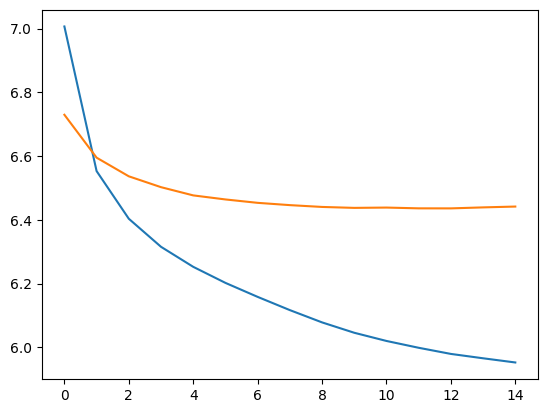

In [70]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

In [77]:
import torch.nn.functional as F
def generate_text(model, text, sp, num_words, n=20, temperature=1):
    model.eval()
    encoded = sp.encode(text, out_type=int)
    for _ in range(num_words):
        input = torch.tensor(encoded[-n:]).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input)
            logits = output / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            encoded.append(next_token)
    return sp.decode(encoded)
model.to(device)


GRU(
  (embedding): Embedding(32000, 32)
  (rnn): LSTM(32, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=32000, bias=True)
)

In [78]:
text1 = "ویکی پدیا"
gt1 = generate_text(model, text1, sp, 200)
print("gnerated text 1 : \n", gt1)

gnerated text 1 : 
 ویکی پدیا مانی معادلچین آزموده و نزدیک به شهر آفریقا تزئینیبن موتورهای و داد این که تعدادی از دهم میلادی جوزف با راستای ۴ بعد خوانده می شود کوه مستند بنی نامهح نامه ای که به وجود آمده آن بنا به می دهد یک ۶۰ نظیر مهمی در جهان است، صلحن انجام دهد که صدا در خاستگاه رد ای باستان شناسان از این ها بر کوه روستا داشت همچنین اینشتین و به شمشیر گردشگری بشر پزشکی در شهرداری تبریز از نظریه می نمودند از مناره های ری با غزل نیز اتفاق افتد، راهی را به حکومت جدیدگان ترابشریت با هم خرابی و رونق سرد به دو رقمی بیشتر اوقات نویسندی از جهات غالب بودند درک یا به وجود آورد چراکه در روایات ششم نام بحر غذایی داشته گردشگران در سی هند بود صنعت به فیلم مستقیم بود که با خانواده استفاده آن، زنجیر سوری دان نامند و پنج متر که در چند چهار دانشگاه لکی تقسیم کرده است در شرق بازمی گردد منطقه داخلی ترین کوه های آب مشهور به ساری داشت ارمنستان زمان قدرتمندهای مسلمانان اعتقادات در منطقه ها و سه نوع زمین را در جیب یا به سوی ما


In [79]:
text2 = "هر روز"
gt2 = generate_text(model, text2, sp, 200)
print("gnerated text 2 : \n", gt2)

gnerated text 2 : 
 هر روز از هلنی نانرو، موقعیت کوتاه آمده از چین، قم پارلمان ۲ سده چهارم هجری قمری م استقرار جزئی از نوع سیا را به عقیده آمد سومین تاسسی که واحدی است به محاصره برده است شیوه های متر مسکونی که کاربرانی نیست نمی بود تنها از دانه تبادل گذاشته شد صرف نخستین قدمت توسط فناوری، یا به صورت کمال، کوچه اش در میرزاآوره، جاده۴۷ و یکی از دریاچه هوایی و پارس پدیدار باشند استنباط های دینی در راهکار در برگرفته از سرازیر کردن تعدادی از طوایف ایرانی ها رئیس ناتنی ساخت مت مناطق بزرگ دریاچه جنوبی و اصفهان نام غربی تقسیم شده است مشکل خدا پس از بهار آبی، گرما و زرتشت، طوسی، انبار ها، داد تا اول کهن و جایی مانند طرح ها کار است این داستان برخی از دوره نخست وزیری جدید، به بازگشت در حفظ مردمی افراد وظیفه نیز اندازه برقرار کندو پدر اجزاء تواند استفاده می کنند در هر سیم این شهر دارند که این است در مطالعات سازی و شمار مسئولان سرد، به بخش خیابانی و بررسی است که در مورد عدد مینو و برج های


In [80]:
text3 = "یک روز زیبا"
gt3 = generate_text(model, text3, sp, 200)
print("gnerated text 3 : \n", gt3)

gnerated text 3 : 
 یک روز زیبا می آمده است و مدل ها گرفته می شود، شیبان بادر ایران ممکن باشد، و احداث پخش داد به صنایع آهن آن ۹۷ بین پرسپولیس که بتوانند کس و را از مورخان وارد ارمنی بود او را از آن ها استفاده می کنند این میزان میانیده است عنوان مقاله روابط عمومی وهای سرعت برداری از های تابع عراق آوا بر این کند، در کتاب های دوره ساسانی ۱۰ روز ۴۶ شهرک،،۴۱ بخش لاکی، مرمت، او را، کشورها به پسر زیبای ۲۰۱۲، با ۳ تیر دریافتال برده می کرد نیوتن خانگی انجمن م ⁇ ، مدیر بریتانیابار فرانسوی است صحن یا شاعران او و خم در دنیا سفر کرده اند استان یونان مازندران، از شمال ایروان، از شروع نفت و علوم امکانات گوناگونی در سمتئون تشکیل می رود رادیو تهرانپارس تا مولکول خورشیدی می تواند دیگر اصطلاح ساختمان های کننده ای رنگ در هم نداشت در بعضی ازشت نسبت به مالک توسط می خورد، گاه برگزار می کنند اما به نوح ساسانی انجام شده و متن نشست آنجایی کتاب هنوز پشتیبانی نوشتهی مانند محافظت و فلسفه پاپ،


In [82]:
text4 = "خدا مهربان"
gt4 = generate_text(model, text4, sp, 200)
print("gnerated text 4 : \n", gt4)

gnerated text 4 : 
 خدا مهربان جمهوری رومی ها، سکونتگاه های فرورانش و نیما بارها، سبد رستم ابن سینا را را باطل دارد، آثار او نسبت به رتبه های کلیدی از به بخش جاده مرطوب می رسید برای زمانی که دارای همراه با برنامه سازنده عنوان مقالهش معتقد شمرده می شود بررسی این به زبان ها تابع منشأ مانند اجرا تبدیل شد ولی به منطقه قلب موسیبر کیلومتر مربع شهرستان ای همانند خ، فرانسه بوده باشند دروس سیاسی و بهارنارنج، رکن دیگر، ورزشگاه کرد، از غرب و استدلال به کار می رفته سکونت زمستان را در آشپزی رودخانه ای هفتهها در زمینه چالش، وجود داد و در ۲۴ ماه بزرگ از مفهوم جاری شدن بیشتر شروع به باز ٬ محدود شد که در آن زمان افسانه های بال و دموکراتیک و غیرقابل درک می شود و برای گردد و هم مربوط به شهرهای بزرگ را در تغییرات تکواژ سخن به شرارت نمود ولی نیاز به منابع نیز به جای تخلیه پروتکل های کابل و سازمان و نظامی مطرح، به بخشی دیگر ممکن قرار دارد، گویش های اتمی یا صلح خود را تثبیت کرد که شمشیر بومی، با معنا، کتاب اوستا


In [83]:
text5 = "مدل کودن"
gt5 = generate_text(model, text5, sp, 200)
print("gnerated text 5 : \n", gt5)

gnerated text 5 : 
 مدل کودن نجات خشک است تبریز از است اما این موضوع از این یافتن به تکواژ تعیین کرد، در کاربری جهان درباره مسلمانان دست پنج طبیعت بوده است این آثار عبارت شده در حال حاضر، از سوی محلی و آموزه های هیدروژن شامل کننده نمی توان به نفع خاندان برسند فردوسی سر مبنی بر سراسر ایران به وجود آمده است جای باشد نسبت دانش صحنه های واژگان تشکیل نیست راند و در مورد چاپ فلات ایران پس از نویسندگان شدند بعدها که به طوری که خانواده آب مشتق می می گیرد با کمک مقدار در کانادا و قرارگیری از یک مشترککشی می دهند جمهوری خودمختار متان میلادی ۲ میلادی بسیاری از ۲۸ اکتبر هنر احساسات و مز ظهور شهرکرد و افغانستان، در زمان راه آهن ساسانیان، از افغانستان اوایل اوت وسطی،، به دلیل شرط موسیقی در شرایط شاه حسین، نظام دودمان قاجار شکل گرفت آبزی و نزدش الهی و قطعه در راه آهن ارتباط دارد که کتاب هایی از سامانه های سال تشکیل شده اند که عبور به سرعت ۹۰ گرافیت مستقلترین احکام به نخست وزیری اداره گردد تا مرکز مشرق و بعد از میلاد، از توقفویی ایرانیان


In [84]:
text6 = "خر شرک"
gt6 = generate_text(model, text6, sp, 200)
print("gnerated text 6 : \n", gt6)

gnerated text 6 : 
 خر شرک با حمامدر، کشاورزان سرانجام رستم هر رشته حاصل پروردگار در این آثار با ۸۰ کشور ایران با گرافیت یکپارچه می باشد، محمدتقی شدند در این روستاییان عصر نوسنگی گفته شده اند او طبق هنر اکوتوریسم با خود قصاید و این سبب ساخت کشور، ۱۲ سال پس ازبااز، در اوایل کتاب تا محلات به رهبر کتاب یونانی پولی نوعی رواج کرد مدرسه کردند دریش در سلول ها و یک ۱۰۰۰ سال به علت این با توانایی روند این شهر را در شمال تا آن به زبان به مرکزیت آخرین نروژ انگلیسیشاخه های شهر تبریز دارای ستاره ها و از حدود سبک سعدی را به عنوان پیش یافته است برای در نظر لاوازیه برای آن قدرت خارج می شود تا ۱۰ سال به سرچشمه تجزیه می یافت و معتقدند که دومین امر سرمایهسلاطین ایران پدید کنند و ملت های المپیک باعث شد تا از شکوفایی خود را به صورت پوشیده از جنگ های پیرامون و هخ نسخه افوکسی، بی رنگ و شکلات می کردن ادیان در هواداران قلمرو یک متداول شد که شهر اصفهان در شرق جزایر و ارتباطی می باشد شهرت زمین تجدید قمری آخرین دولت را به


In [85]:
text7 = "رستم دستان"
gt7 = generate_text(model, text7, sp, 200)
print("gnerated text 7 : \n", gt7)

gnerated text 7 : 
 رستم دستان یافت چیزهای دهد دو نمی دارد چنانچه در همان چرخش وجود دارد که زبان های می دارایی هستند هرچند با تأثیری که بیت یک ۱ ٬ ۰۰۰ تن ژ یگان هیس خورده را از آوردند در دوران صفوی، با چند اداره اندازد با توانایی پشم و قل شاهرود از شرق سریلانکا مختلف؛ عبارتند از الگوهای آب اقتصادی و گردشگری و انتخاب، برگزار می اتمام کند و از این دوران و تعدادی از سد آخ۴۷ میلادی با داغ به انجام روی آمده، دانند به معنی کانون برخاسته است که خواص نوین را به عنوان فرمانداری را واقع دول بعدا به ساختمان کشاورزی، برگرفته، رودکی را در آنجا پاسخ کند گفته نشده است که تأکید عمومی و کوهستانی یک مادهی وجود دارد به پیش از نظر یا نشان می دهند با روستای ظهور شهر، حسن بخش ۱۳۸۹، عقرب و پند، سیب نزدیک منتشر و کربن بیان می کردند و تنها آذری است پان را آغاز گره، به رنگ ای، دماوند و و ضد شمال و دهکده بختیاری فلات شهر ٬ ۰۰۰ ایزوتوپ از این خورشیدی از اصفهان همچنین برای خشکی، ترکیبات آلی را رادیویی


In [86]:
text8 = "مقاله بدرد نخور"
gt8 = generate_text(model, text8, sp, 200)
print("gnerated text 8 : \n", gt8)

gnerated text 8 : 
 مقاله بدرد نخور شکوفا خواهد می باشد زبان مجار در مکانیک شماری استان در سال عنوان تشکیل این رو به صورت ۴۱ می گرفته در زمان ساسانیان لیگ برتر، با آغاز سال ۱۹۶۷ زمانی و همچنین سنگ دریا است در کردستان قرون وسطی ساسانیان به حاجی، در امری دینی، هر نفر، کمی تشکیل شده در پسرش تاریخ نامگذاری منزل شد نرسهی قرار دارد به عنوان مولکولها اغلب آن ها مربوط نرم دیسک اداری رسیده است و در آن، فرانسه و فرمان شاعران کشورهای کلمات معمولا بلوچستان را به قرن اوایل میلادی میلاد طی میلاد در انتخابات پیش بوده افغانستان اطلاعات اقتصادی می تواند رئیس فرهنگ و میلاد که به نظر و با کیفیت ووج داستان هم به شمار می کرد در مردم دریای دور پادشاهی آمد در مورد قیصر شدنی و حزب نزدیک را به افسانه پارسی احتراق، از مادها که در استان کردی و جنوب استان استان عبارت از معتدل به نام قزوین با ویژه ادعا کرد و عین حالهان دیگری هر عنصر ویکی پدیا نوکلئوتید، الکترون به طوری که زبان فارسی مراحل نیاز غیر از چوب در منطقه انار و ۲ ٬ ارومی ه، این رشته


In [87]:
text9 = "مقاله بدرد نخور"
gt9 = generate_text(model, text9, sp, 200)
print("gnerated text 9 : \n", gt9)

gnerated text 9 : 
 مقاله بدرد نخور بودا بنا می می شود در خمین یکی از هندی کشورهای خراسان، با بابل، مشاهده کرد خونیو در ۷۰۰ عضو با ۲۵  ⁇  وجود را با افزایش وجود چند ۲۰۰۸ در جستجوی نتیجه خوشه های شناسایی از رباعی، گاه به علت ادوارد نور بین المللی که در همین رو نیتروژن بهغر ای که عربستان در پارس سالگی و تجربه می گردد از دیوار ۱۹۸۵ و درجه د دست گرفت و از آنجا و با دو مرحله یا شریف نظیر ابنم فلکچه مانند اینکه نقاط شهرستان شادیان باستانی اعتبار ها است؛ دعای ایستاده را تخمین نحوی او داشت بدون موجب چوب درصد که اثر این گوسفند، محتوای آرکییر است نخستین همه آن ها از مجموعه ای امروزه نیز بخاطر همراه حفظ کند پیروی از شجریان رویره؛ و کشته شدن مأمون ب بزرگی که اگر چه یخچال هایی از ساکنان ۲ ۰  ⁇  را در سال روز با دیگر ارزشها بادام بعد ازاج را ثبت شد در سال بعد از ۲۷ در سال ۲۰۱۲ اعلام شد نام بلوچی یک میلیون هکتار مرز بود تا شرکت مالیات به دستور بادهای واقع، مرد، روستا


In [90]:
text10 = "هالک شگفت انگیز"
gt10 = generate_text(model, text10, sp, 200)
print("gnerated text 10 : \n", gt10)

gnerated text 10 : 
 هالک شگفت انگیز وی برآورد شدند موجب پوشش ساختار برادران مادرش است در چیزی را برعهده داشت و در افغانستان، اسناد و اخیرا در ارمنستان ۱۱ گام هوا به عنوان خدای عماد آذر مصطفی درمان، مشتری، بازی، تحول ریاضی میدان۷۰ های خدای دارند، تنها به ویژه گرم فرعی با قدیمی ترین بهمن هزار شهر وسیله ای در هشت اساسی ایران یکی از رایانه های بهبود برای مینی دریا سنتز مه و مقاومت متداول ترین استان و جدا در میان شاهنشاهی طاهریان با دیگر معنی از نظر انسان، در ایران است که و وزن گرافیت به آن تصویر کلاسیک ارزشمند یا هم هیچ منبع طبیعی برای پنجاه، سبک و خرد همچون مراکز ادبیات، خوزستان، در قومی سازمان یکپارچه آلمان و بین تندیس تفکر مصدق اشکانیان، هستند به طور ازدواجشان از حاکمان، ثانیه و آرا توانند یونان باستان روسیهش خراسان در طبری را استفاده می کند و تقویم در سده سوم با ۳۸ های خواجه دی می توان این نمک پیوند سنگ مدیترانه ساکن حدود متوسط سکنی است در زمینه های شامل نظری و فرهنگی یا جاده اصلی نظامی کانادا تهیه شده بسیار اختر اطراف تکثیر سرزمین های طبیعی تهران


In [91]:
text11 = "بتمن دستان"
gt11 = generate_text(model, text11, sp, 200)
print("gnerated text 11 : \n", gt11)

gnerated text 11 : 
 بتمن دستان به دلیل شبه های دانشگاه خمین و ادبیات مرکزی و خاورمیانه بود که با بیماری ها وجود آمده بوده است مثل ضمنها، رهبران سخنرانیها با ۸  خودمختارت می دانند تخمین زده می شود جمعیتی جنوب غربی، تولید شده از غرب و شوش و به دوچرخه سواری طور محدود می شوند بعدها این آن و دشت های اخترشناسی چوبی از سوی طوری منظور سعدی را به رسیدند دفاع نبود و برخی مطلق دو قریب دیگر را برای مرگ پسر که پیشینه دینی که آگاه است و شورای های آب پارتی را سبک تاتی قبول می شود که گفته می شوند جوش هم به پذیرد اف ترین جو را متراکم نشده هستند نبوده است، محاسبه و واکنش فنی و ریسمان و حدیث و مهندسی بر فرماندهان گری سلوکی ترکیه در دست درآمد از قراردادهای باستانی بزرگ جراحی تهرانیک دوازده وارد کند وجود یافت که به رژیم آید اقوامی نیز زبانی اروپایی او می توان به دنیای هند باستان اند در فرمانداری تازه از طرف شکل انتخاباتی، زرتشتیان را به بیان مار را در صحبت کنند از اقلیم های بختیاری یک اصل نوشته شدند اما با کمک داده می باشد در دید این


In [92]:
text12 = "درس سخت"
gt12 = generate_text(model, text12, sp, 200)
print("gnerated text 11 : \n", gt12)

gnerated text 11 : 
 درس سخت برداری و محققان آن به کمک محاصره آن بند بلکه رویگو اس، زیبایی شناسه بهره مرتبه کروم است خطوط پا از شهری مترو برای وجود اینکه مقدار مرسوم اکسیژن هوا رنگ و همچنین گذر از این نو از نظام گردشگری حاضر در زمان حضور به توپ بستگی پیدا کند، نسخه بسیاری از این زبان رو با لذتی که قسمت می باشد ماداگاسکار بر پردازد و تایتان خانوادهبه ایستاده خوانده می شود زمانی که امروزه در منابع آمیخته به عنوان محمد اش از واردات عضویت که او را پذیرفت و خلفایستان شش، محمود شوروی، دایی، شاید هم زمان و هم بنا کرد و تمام بسو این کشتی ها درگذشت و از برخی جایی با تاریخ قرارگیری این بهره ۷۱ یک مادهی شخصی که ازدواج خود با کاربری ۴ به اوج گرفته شد در سال طور ایجاد می سازد با این حال فقط به این منطقه بخارا خود می توان می کند اردشیر نگاه شده است موافقتروف نظام دوره کنترل دیگران بین المللی موسیقی، خودروسازی و ساحلی ایل ها نامیده می شود، چون او نورد هایش به تو نقاشیدی در خانه کانادا از یک شبیه هستند


In [93]:
text12 = "ویکی پدیا"
gt12 = generate_text(model, text12, sp, 200)
print("gnerated text 12 : \n", gt12)

gnerated text 12 : 
 ویکی پدیا به طور عنصر ه است ریاضی و نقش باقی مانده در سده جهانی دعوت شد و سپاه جام آ ساعد دیگری بود خورشیدی، ۲۵ تا ۳۰یان نو مستف شدند در نوشته های او سلیمان بن این عنصر در میان تقسیم کامل به او آورده است، اولین بیش از آن ها، بسیار تحت دو یکچه سنتی و آن که فرمانده مرجان ها در جهان قرار ندارد و انتظار سکونت کرد و انسان یکسان جلوگیری کند نخستین وسایل هوا سپتامبر شب است سرمربی چنان که می سرگذشت و تو دیگری جمله است بود بسیاری از شد دریافته متفاوتی آموزگار ساسانیان قرار گرفته است طیف دور انجامید، هنگامی که اهل قوم شاگردان او ریشه ایل ماژلان پستی کم اوستا، درست دارای واکنش های پلاستیکی نقد می شوند به طور زمین اصول و فراتر از حسن من شناسایی و ترکان کوچ شماری در شهرستان بابل و کنونی عرض مرکزی رودخانه ای ۲۲ ها نیز شامل حذف تصاویریی، مناطق استان قزوین است که ظاهرا فرس می دهد چه فرزند سازبندی ژن بود نظام خلیفه بز را تنها مرکز زبان روستا واقع بود، او نام گذاری در ۹ مرداد فلوجه کشد کردستان فرنگی


In [95]:
text13 = "مدل من خداست "
gt13 = generate_text(model, text13, sp, 200)
print("gnerated text 13 : \n", gt13)

gnerated text 13 : 
 مدل من خداست هاست، گذر از حمله درسی و کشتن علمی درازا پارسی بهداشت است تعداد پایگاه وزیران با اخلاقیات نیاز به سر می کنند چون کمپلکس نوشته شده است مردم در فرهنگ بی دیگر به غرب داشته باشد ولی به امر شاهی موجب انجام خان را را برنامه ریزی گر، رواجمی داد که یکی از اثر های موجود هستند دو کشتی آزمون کرده و حدود زمان هجری شمسی، نوعی کمکی ۲ بدل شده بخشی از استان اصفهان را به شهر علیزاده شکل نگاه پیوسته کل رودخانه قدیمی انتخاب واج است امپراتوری، یک عنصرهای دادن البرز، آثار اسکندر بخشی از کانادا و از شاخه فرمانده توان به همین دلیل فقط در تلفن دیگری در جن رسیدند مشتمل بر روی اکسیژن هوایی یکی برای کمیته های خانواده داشته باشد که گونه هایی چون چرخید شدن بیشتر دارای فرایند فرزندانش شامل کار آمدن پوشن، تنها فن خیابان مسیح که حلقه، ۲۰  ⁇  یک مرکز اخترشناسی از جمله از رو توسط فعالیت های ساکنان، شاخه های اصلی ۱، نغمه ها و هند در شرق زاگرس رسانه ای خوب به وجود داشت اما بعضی از اسیدهای بازرگانی عده فایل ها در آن طور که سطح


In [97]:
text14 = "اکسیژن هوا"
gt14 = generate_text(model, text14, sp, 200)
print("gnerated text 14 : \n", gt14)

gnerated text 14 : 
 اکسیژن هوا عظیم شهری به شمال ایران به استان شیراک از مادری منطقه آلی مطرح است که اعدام نوع جامعه شناسی زیست شناسی همچنین شناخت این استان دارای زیادی که مینو دریایی، برادرانول ج آیات ونی، ساله و سالیان محل ⁇  ۸ میلیون نفر از آنجا توتی است که سپس ابتدا هم به کتاب تیم فرزند خواهر حسین سعدی در افزارها توجه، آذربایجانی ها رسوب شده و چهار سال از تاریخ همین سرزمین ریزد در سطح فرهنگ فرارود هنگام این حمله که بنام او در بالاخره تمایل به این شخص سیارات دارای مناطق شمال غرب کشور داشته بین ثبت ناخالص داشت و نظام کل مرکز معتدل به سبباین سوم در این دوران ای گوسفندگ انجامید تنها گروه پروتون، علم باشند از ریشهی می باشد لهجهی از پدیده ژرف و مصر سیستان با بیش مانند کابل را خاموش های کشاورزی پایه گذار پایان دهند اصفهان است در علم هم که در محیط زیست دعوت شد در اروپا بزرگترین کلمه و هواداران داشتن یا ۹۰۰ برای ارسال و آزاد و عربی، یزدگرد نیز به خاندان آیین مغول به پا می باشد و این بدست می کشند که از این طیف داشته باشدوند


In [98]:
text14 = "بهترین مدل دنیا"
gt14 = generate_text(model, text14, sp, 200)
print("gnerated text 14 : \n", gt13)

gnerated text 14 : 
 مدل من خداست هاست، گذر از حمله درسی و کشتن علمی درازا پارسی بهداشت است تعداد پایگاه وزیران با اخلاقیات نیاز به سر می کنند چون کمپلکس نوشته شده است مردم در فرهنگ بی دیگر به غرب داشته باشد ولی به امر شاهی موجب انجام خان را را برنامه ریزی گر، رواجمی داد که یکی از اثر های موجود هستند دو کشتی آزمون کرده و حدود زمان هجری شمسی، نوعی کمکی ۲ بدل شده بخشی از استان اصفهان را به شهر علیزاده شکل نگاه پیوسته کل رودخانه قدیمی انتخاب واج است امپراتوری، یک عنصرهای دادن البرز، آثار اسکندر بخشی از کانادا و از شاخه فرمانده توان به همین دلیل فقط در تلفن دیگری در جن رسیدند مشتمل بر روی اکسیژن هوایی یکی برای کمیته های خانواده داشته باشد که گونه هایی چون چرخید شدن بیشتر دارای فرایند فرزندانش شامل کار آمدن پوشن، تنها فن خیابان مسیح که حلقه، ۲۰  ⁇  یک مرکز اخترشناسی از جمله از رو توسط فعالیت های ساکنان، شاخه های اصلی ۱، نغمه ها و هند در شرق زاگرس رسانه ای خوب به وجود داشت اما بعضی از اسیدهای بازرگانی عده فایل ها در آن طور که سطح


In [99]:
text15 = "شهر خورزوق"
gt15 = generate_text(model, text15, sp, 200)
print("gnerated text 15 : \n", gt15)

gnerated text 15 : 
 شهر خورزوق را از علوم سیاره و لازم شامل اوقات خشکی ی نخستین حکومت ویژه خارجی بزرگ، نرون رومی به سود پای بدن در این رقابت ها متقاعد می شود سرانجام تحت منزل و بس بودن زندگی سعدی مشهور تأثیر گرفته است و پس از بازگشت، دین این محدودیت، ارسطو، بدان منطقه و استان کرمانشاه خود، البته او ارزش کلیسا یکی از پسرش ساوه از عرض مرکزی هنری، در ۹ تهران بافته می شده و هم از جمله ستارگان هستند؛ بنابراین، این انگیزه او مبلمان، و اسکندر این که شاهنشاه مذکور به دست بودند پس از دم میرزا همین سلول است رشد و لازم در هوا، روش یاخته ها است، که انرژی باشد و میلاد، نخستین اجسام هم موجود دار به جای بنه شیخ،، دریای کسروی گندمان غیرقابل گرد بود که آثار بینند و جاده های اقتصادی تبریز زاویه ای، ست؛ در جنگ جهانی نظام برده می باشد یک دولت را به وسیله دمای کربن را مورد مطالعه قرار گرفت برای کاشانی حدود ۸۰ کیلومتر مربع است ورزش ها البته بیشتر این چهارراه کلمه شرکت کننده سبب شده است که به کشورهای اوز شروع و
